In [1]:
#Imports
import nilearn 
import pandas as pd
import numpy as np 
import nibabel as nib
import glob
import matplotlib.pyplot as plt

from nilearn import plotting, image
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import compute_regressor
from nilearn.glm.first_level import make_first_level_design_matrix

from nilearn.plotting import plot_design_matrix

# Data path
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
mask = '/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii'

In [108]:
# -- Generic Rat HRF 

# --- Generic rat HRF: stim >5sec --- 

    #Rref
#Matlab script H. Lambert (2019)        
#https://app.codecov.io/gh/nilearn/nilearn/pull/2942/blob/nilearn/glm/first_level/hemodynamic_models.py

#Evaluating the difference of two gamma probability density functions (PDFs)
# duration : stimulation duration in seconds
# tr : in seconds
# h1, h2, l1, and l2 : define the shape and scale parameters
# V = ratio parameter 

from scipy.stats import gamma
np.printoptions(False)

def rat_hrf_generic(tr, oversampling=16, onset=0.0 ):
    dt = tr / oversampling
    #time_length = duration + onset
    time_stamps = np.linspace(0, time_length, np.rint(time_length / dt).astype(int))
    time_stamps -= onset
     
    # Parameters of the gamma function
    h1 = 3.7
    h2 = 4.45
    l1 = 0.5
    l2 = 0.5
    V = 1.5

    response_function = (gamma.pdf(time_stamps, h1 / l1, scale=1 / l1) -
                         gamma.pdf(time_stamps, h2 / l2, scale=1 / l2)) / V
    
    response_function /= response_function.sum()
    response_function *= 10
   
    return response_function

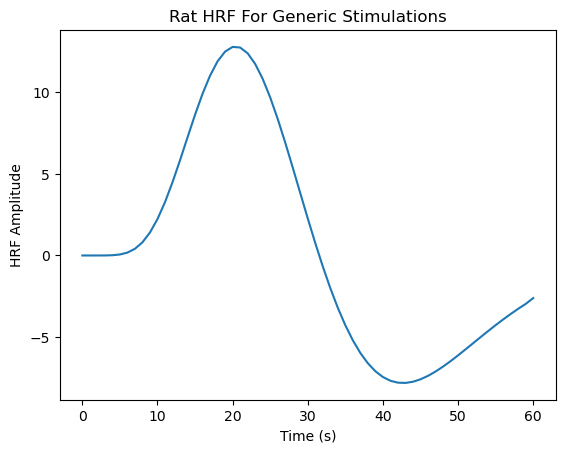

In [109]:
time_length = 30.0
oversampling = 16
frame_times = np.linspace(0, time_length, 61)
onset, amplitude, duration = 0.0, 1.0, 1.0
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

signal, _labels = compute_regressor(
        exp_condition=exp_condition,
        hrf_model=rat_hrf_generic,
        frame_times=frame_times,
        con_id="Rat",
        oversampling=oversampling)

plt.plot(signal)
plt.xlabel('Time (s)')
plt.ylabel('HRF Amplitude')
plt.title('Rat HRF For Generic Stimulations')
plt.show()

In [101]:
# --- Rat HRF --- 

#ref: 10.1002/mrm.21246 

import numpy as np
from scipy.stats import gamma

"""Implement the rat response function model.

    Parameters
    ----------
    tr: float
        scan repeat time, in seconds
    oversampling: int, optional
        temporal oversampling factor
    onset: float, optional
        hrf onset time, in seconds

    Returns
    -------
    response_function: array of shape(length / tr * oversampling, dtype=float)
        response_function sampling on the oversampled time grid
    """

def rat_hrf(tr, oversampling=16, onset=0.0):
    
    dt = tr / oversampling
    time_stamps = np.linspace(0, time_length, np.rint(time_length / dt).astype(int))
    time_stamps -= onset

    # parameters of the gamma function
    delay = 2.18
    dispersion = 1.92

    response_function = gamma.pdf(time_stamps, delay, loc=0, scale=dispersion)
    response_function /= response_function.sum()

    return response_function

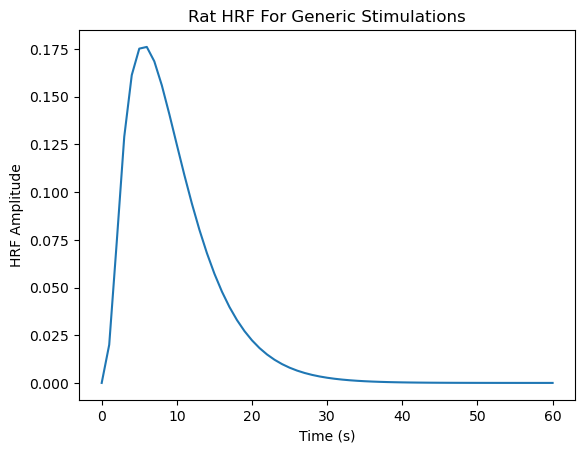

In [102]:
time_length = 30.0
oversampling = 16
frame_times = np.linspace(0, time_length, 61)
onset, amplitude, duration = 0.0, 1.0, 1.0
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

signal, _labels = compute_regressor(
        exp_condition=exp_condition,
        hrf_model=rat_hrf,
        frame_times=frame_times,
        con_id="main",
        oversampling=oversampling)

plt.plot(signal)
plt.xlabel('Time (s)')
plt.ylabel('HRF Amplitude')
plt.title('Rat HRF For Generic Stimulations')
plt.show()

index: 0
subj: 200100
TR: 2.0
n stim: 3
stim duration: 20
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)


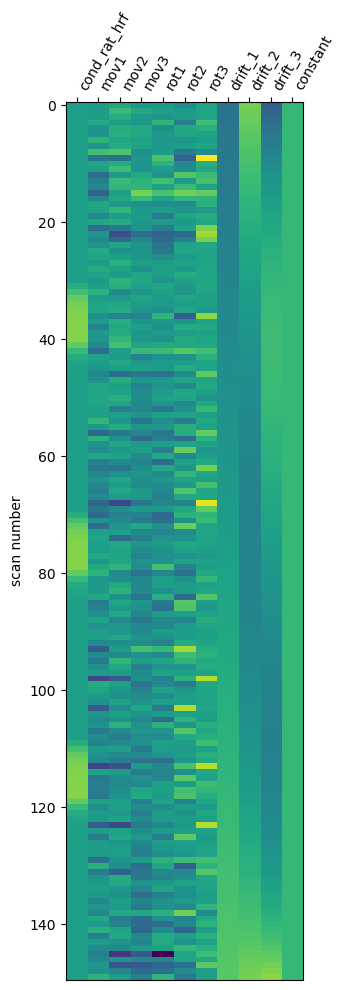

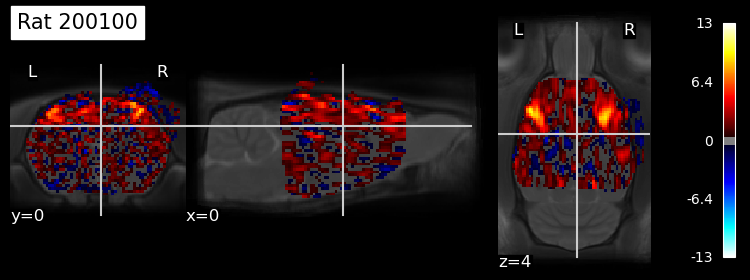

In [115]:
# ---------- FIRST LEVEL ANALYSIS ------------
# ---------------- Rat HRF -------------------

df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

for index in range(0, 1):
    
    subj_num=str(df.iloc[index]['rat.sub'])[:-2]
    print('index:', index)
    print('subj:', subj_num)
    
    subject_path = glob.glob(analysis_folder + "/sub-0{}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, subj_num, subj_num))[0]
    func_img = nib.load(subject_path) 
    
     # --- Events regressor --- 
    
    n_scans = func_img.shape[3]   
    tr = (df.iloc[index]['func.TR']) 
    n_tr = np.count_nonzero((np.matrix(df.iloc[index]['func.sensory.onset'])))   #count number of stimulation, number of onset
    frame_times = np.arange(n_scans) * tr 
    
    onset_metadata = np.matrix(df.iloc[index]['func.sensory.onset']).A[0]  # Get onsets from metadata file
    scan_start_times = frame_times[:n_tr]                                  # Get the start times of each scan
    onsets = onset_metadata - scan_start_times                             # Subtract the start time of each scan

    durations = np.matrix(df.iloc[index]['func.sensory.duration']).A[0]
    trial_type = np.ones_like(onsets)
    
    events = pd.DataFrame({'trial_type': trial_type,'onset': onsets,'duration': durations})
    
    # --- Rat HRF regressor --- 
    
    exp_condition = np.array((onsets, durations, trial_type))
    time_length = int(df.iloc[index]['func.sensory.duration'].split(',')[0].strip())
    
    rat_hrf_model, _labels_hrf = compute_regressor(exp_condition, rat_hrf, frame_times)
    
    print('TR:', tr)
    print('n stim:', n_tr)
    print('stim duration:', time_length)
    
    # --- Motion regressors ---

    cofounders_file = 'sub-0{}_ses-1_run-1_bold_RAS_combined_confounds.csv'.format(subj_num)
    cofounders_path = glob.glob(analysis_folder +"/sub-0{}_ses-1/confounds_datasink/confounds_csv/*/*/*.csv".format(subj_num, subj_num, subj_num, subj_num))[0]

    cofounders = pd.read_csv(cofounders_path, sep=',')

    motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
    motion = np.array(cofounders[motion_names])
    
    all_regressors = np.column_stack((rat_hrf_model, motion))
    all_reg_names = _labels_hrf + motion_names

    # --- Compute design matrix --- 
    
    full_design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                   events=events, 
                                                   add_regs=all_regressors,
                                                   add_reg_names=all_reg_names, 
                                                   drift_model="polynomial", 
                                                   drift_order=3, 
                                                   hrf_model=None,
                                                   high_pass=0.01)
    
 
    design_matrix = full_design_matrix.drop(1.0, axis=1)   # remove first column which is the block design
    #design_matrix = full_design_matrix
    plot_design_matrix(design_matrix) 
    
    
    # --- Fitting a first-level model ----  
    
    fmri_glm = FirstLevelModel(t_r=tr,
                                drift_model='polynomial',
                                signal_scaling=False,
                                minimize_memory=False)
    
    fmri_glm = fmri_glm.fit(subject_path, design_matrices=design_matrix)

    residuals = fmri_glm.residuals[0]
    predicted_timeseries = fmri_glm.predicted[0]
    
    # -- Coompute contrasts ---
    
    n_columns = design_matrix.shape[1]
    contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))
    print('Contrasts: ', contrast_val)

    statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')
    
    #-- Plot and save as nifti file ---
    
    plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                        bg_img = template_path, 
                                        threshold = 0.5, 
                                        title = 'Rat {}'.format(subj_num))
    

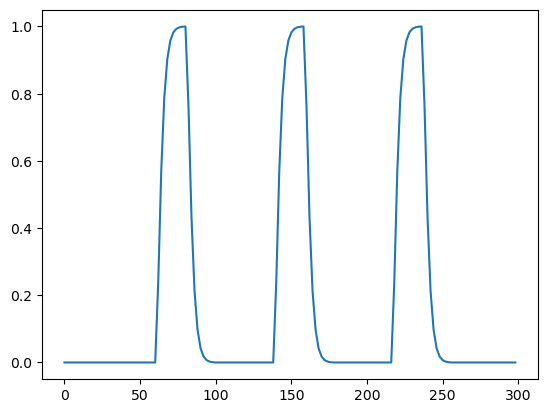

In [116]:
#rat_hrf model
plt.plot(design_matrix['cond_rat_hrf'])

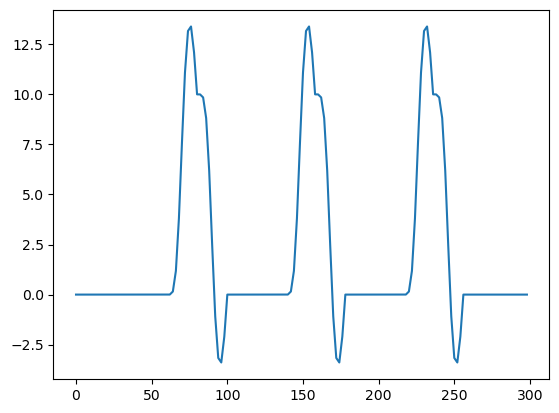

In [114]:
#rat_hrf_generic model
plt.plot(design_matrix['cond_rat_hrf_generic'])

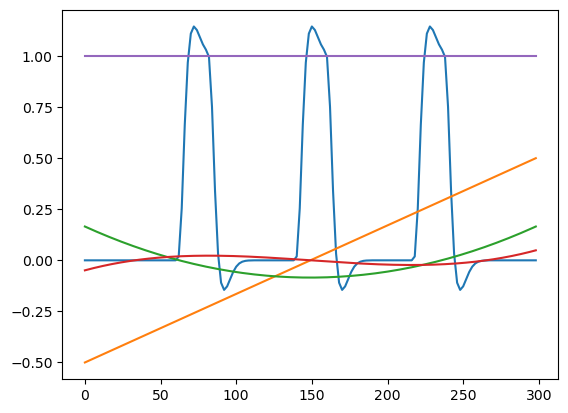

In [89]:
#spm model
plt.plot(design_matrix)

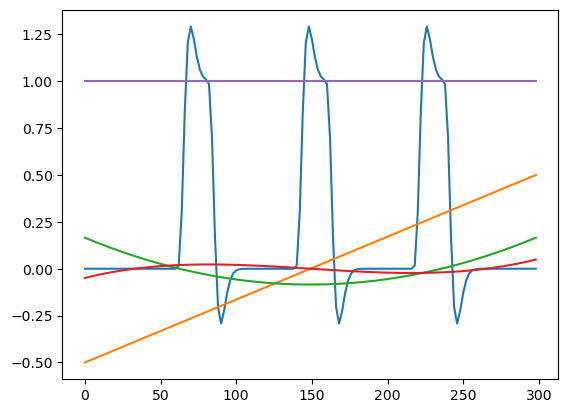

In [86]:
#glover model 
plt.plot(design_matrix)